<h2>Notebook to match the correct local tax rates to each apartment<h2/>

<a id="0"></a> <br>
## Table of Contents

1. [Load data](#1)
2. [Read polygon-map with municipalities in Switzerland](#2)
3. [Test Polygon Conversion from 3D to 2D](#3)
4. [Apply Polygon Conversion to entire dataset](#4)
5. [Convert LV95 coordinate system to WGS84 system](#5)
6. [Intersect municipality polygon-map with lat and lon (point-in-polygon intersection)](#6)
7. [Merge with tax rates based on BFS number](#7)
8. [Clean up dataframe](#8)
9. [Safe to csv](#9)


In [1]:
# Libraries
import os
import requests
import json
import urllib
import fnmatch
import folium
import platform
import pandas as pd
import geopandas as gpd
from IPython.display import clear_output

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a> <br>
## Load csv files into dataframes

In [3]:
df_locationfile = pd.read_csv('../TablesDB/Location_v3_enriched.csv')
df_locationfile.head()


,LocationId,Street,ZIP,longitude,latitude,#supermarkets,#foodandbeverage
0,78753131-6d78-4d1e-a0e5-fc8b5f430570,NaN,6598.0,8.849665,46.175962,2,3
1,f0c2bc0e-55ab-4eb1-98fa-edcb4a0ee01e,via albonago 43,6962.0,8.974113,46.013360,0,3
2,fbdcde66-0fd7-4304-a83e-70ecbb0f6ae7,Via San Gottardo 41,6500.0,9.032918,46.201556,0,1
3,2d7451a3-d7e1-4dc7-babf-ab237f2c02e4,Via F. Zorzi 17,6500.0,9.015443,46.187900,0,6
4,2bde1434-f480-4d46-9b05-99e0c0659671,Via San Gottardo,6900.0,8.941940,46.015976,3,3


In [5]:
columns_taxes = ['Kantons-Id','Kanton','BfS-Id','Gemeinde','Einkommenssteuer_Kanton','Einkommenssteuer_Gemeinde','Vermögenssteuer_Kanton','Vermögenssteuer_Gemeinde']
df_taxes = pd.read_csv('estv_income_rates.csv')[columns_taxes]
df_taxes.head()

,Kantons-Id,Kanton,BfS-Id,Gemeinde,Einkommenssteuer_Kanton,Einkommenssteuer_Gemeinde,Vermögenssteuer_Kanton,Vermögenssteuer_Gemeinde
0,1,ZH,131,Adliswil,99.0,102.0,99.0,102.0
1,1,ZH,241,Aesch (ZH),99.0,91.0,99.0,91.0
2,1,ZH,1,Aeugst am Albis,99.0,95.0,99.0,95.0
3,1,ZH,2,Affoltern am Albis,99.0,124.0,99.0,124.0
4,1,ZH,211,Altikon,99.0,114.0,99.0,114.0


<a id="2"></a> <br>
## Read polygon-map with municipalities in Switzerland

In [30]:
# Polygonmap als .shp file (WGS84)
columns_polys = ['BFS_NUMMER', 'NAME', 'geometry']
polys = gpd.read_file("swissBOUNDARIES3D_1_5_TLM_HOHEITSGEBIET.shp")[columns_polys]
print(type(polys))
polys


<class 'geopandas.geodataframe.GeoDataFrame'>


,BFS_NUMMER,NAME,geometry
0,131,Adliswil,"POLYGON Z ((2682588.433 1239418.954 452.658, 2..."
1,3714,Rheinwald,"POLYGON Z ((2747636.177 1152720.387 3027.324, ..."
2,5722,Grens,"POLYGON Z ((2505186.356 1139817.844 479.792, 2..."
3,6730,Val Terbi,"POLYGON Z ((2602713.788 1239572.350 1145.337, ..."
4,4123,Windisch,"POLYGON Z ((2659073.266 1256864.692 420.038, 2..."
...,...,...,...
2152,5803,Vulliens,"POLYGON Z ((2550131.374 1165571.624 556.253, 2..."
2153,4002,Biberstein,"POLYGON Z ((2647689.000 1251236.794 360.247, 2..."
2154,6157,Val-d'Illiez,"POLYGON Z ((2561925.145 1113525.804 3115.366, ..."
2155,4841,Pfyn,"POLYGON Z ((2716082.869 1274310.216 468.667, 2..."


<a id="3"></a> <br>
## Test Polygon Conversion from 3D to 2D

POLYGON Z ((2682588.433 1239418.954 452.658, 2682570.62 1239425.309 452.6, 2682546.593 1239387.066 454.76, 2682537.348 1239378.085 455.356, 2682522.475 1239367.483 456.298, 2682518.495 1239362.011 456.553, 2682517.524 1239351.642 456.977, 2682516.28 1239345.061 457.438, 2682514.381 1239340.655 458.32, 2682495.247 1239319.556 458.901, 2682490.585 1239316.999 459.063, 2682486.79 1239315.706 459.367, 2682481.782 1239316.014 459.701, 2682475.663 1239317.605 460.508, 2682470.959 1239316.626 460.697, 2682467.38 1239312.598 461.196, 2682462.808 1239298.66 462.3, 2682459.791 1239296.448 462.875, 2682453.464 1239294.259 463.613, 2682445.246 1239289.446 465.139, 2682440.999 1239287.959 465.264, 2682420.26 1239288.421 465.901, 2682412.466 1239293.258 466.579, 2682402.559 1239295.46 467.344, 2682399.899 1239293.942 467.666, 2682398.04 1239282.616 468.289, 2682398.969 1239272.849 468.792, 2682394.214 1239267.875 469.35, 2682388.484 1239268.555 470.03, 2682368.131 1239280.383 470.723, 2682352.884 12

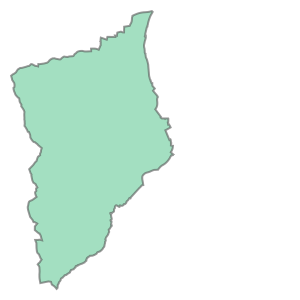

In [52]:
from shapely import Polygon, MultiPolygon

test = polys['geometry'].iloc[0]
print(test)
test2= shapely.transform(test,lambda x: x,include_z=False)
print(test2)




<a id="4"></a> <br>
## Apply Polygon Conversion to entire dataset

In [57]:
import geopandas as gpd
import shapely

# Make a copy of the original GeoDataFrame
polys_2d = polys.copy()

# Define a function to remove the Z coordinate from a geometry
def remove_z_coordinate(geom):
    return shapely.ops.transform(lambda x, y, z: (x, y), geom)

# Apply the function to the 'geometry' column
polys_2d['geometry'] = polys_2d['geometry'].apply(remove_z_coordinate)

# Print the first few rows of the modified GeoDataFrame
polys_2d.head()


,BFS_NUMMER,NAME,geometry
0,131,Adliswil,"POLYGON ((2682588.433 1239418.954, 2682570.620..."
1,3714,Rheinwald,"POLYGON ((2747636.177 1152720.387, 2747627.823..."
2,5722,Grens,"POLYGON ((2505186.356 1139817.844, 2505187.470..."
3,6730,Val Terbi,"POLYGON ((2602713.788 1239572.350, 2602704.990..."
4,4123,Windisch,"POLYGON ((2659073.266 1256864.692, 2659021.475..."


POLYGON ((2682588.433 1239418.954, 2682570.62 1239425.309, 2682546.593 1239387.066, 2682537.348 1239378.085, 2682522.475 1239367.483, 2682518.495 1239362.011, 2682517.524 1239351.642, 2682516.28 1239345.061, 2682514.381 1239340.655, 2682495.247 1239319.556, 2682490.585 1239316.999, 2682486.79 1239315.706, 2682481.782 1239316.014, 2682475.663 1239317.605, 2682470.959 1239316.626, 2682467.38 1239312.598, 2682462.808 1239298.66, 2682459.791 1239296.448, 2682453.464 1239294.259, 2682445.246 1239289.446, 2682440.999 1239287.959, 2682420.26 1239288.421, 2682412.466 1239293.258, 2682402.559 1239295.46, 2682399.899 1239293.942, 2682398.04 1239282.616, 2682398.969 1239272.849, 2682394.214 1239267.875, 2682388.484 1239268.555, 2682368.131 1239280.383, 2682352.884 1239288.444, 2682346.801 1239294.616, 2682341.808 1239296.223, 2682336.599 1239296.212, 2682331.814 1239294.872, 2682324.726 1239285.984, 2682320.384 1239282.945, 2682314.73 1239276.035, 2682313.38 1239268.326, 2682314.645 1239251.77, 2

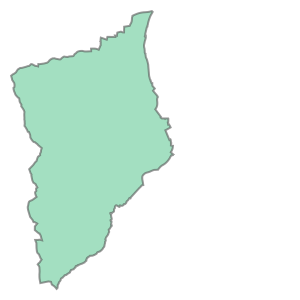

In [58]:
test = polys_2d['geometry'].iloc[0]
print(test)
test

<a id="5"></a> <br>
## Convert LV95 coordinate system to WGS84 system

In [60]:
#convert LG95 coordinates to WGS84 coordinates
wgs84_crs ="EPSG:4326"
polys_2d.crs = "EPSG:2056"
polys_2d = polys_2d.to_crs(wgs84_crs)
polys_2d.head()


,BFS_NUMMER,NAME,geometry
0,131,Adliswil,"POLYGON ((8.53066 47.30049, 8.53043 47.30054, ..."
1,3714,Rheinwald,"POLYGON ((9.36238 46.50950, 9.36227 46.50941, ..."
2,5722,Grens,"POLYGON ((6.20569 46.40300, 6.20571 46.40297, ..."
3,6730,Val Terbi,"POLYGON ((7.47451 47.30702, 7.47440 47.30702, ..."
4,4123,Windisch,"POLYGON ((8.22206 47.45991, 8.22137 47.46008, ..."


<a id="6"></a> <br>
## Intersect municipality polygon-map with lat and lon (point-in-polygon intersection)

In [61]:
# lat/lon to GeoDataFrame
pnts = gpd.GeoDataFrame(df_locationfile, 
                        geometry = gpd.points_from_xy(df_locationfile['longitude'], 
                                                      df_locationfile['latitude']))

pnts.head()

,LocationId,Street,ZIP,longitude,latitude,#supermarkets,#foodandbeverage,geometry
0,78753131-6d78-4d1e-a0e5-fc8b5f430570,NaN,6598.0,8.849665,46.175962,2,3,POINT (8.84967 46.17596)
1,f0c2bc0e-55ab-4eb1-98fa-edcb4a0ee01e,via albonago 43,6962.0,8.974113,46.013360,0,3,POINT (8.97411 46.01336)
2,fbdcde66-0fd7-4304-a83e-70ecbb0f6ae7,Via San Gottardo 41,6500.0,9.032918,46.201556,0,1,POINT (9.03292 46.20156)
3,2d7451a3-d7e1-4dc7-babf-ab237f2c02e4,Via F. Zorzi 17,6500.0,9.015443,46.187900,0,6,POINT (9.01544 46.18790)
4,2bde1434-f480-4d46-9b05-99e0c0659671,Via San Gottardo,6900.0,8.941940,46.015976,3,3,POINT (8.94194 46.01598)


In [64]:
# Merge spatial data
data_merged = gpd.sjoin(pnts, polys_2d, how="inner", op='within')

data_merged.head()



,LocationId,Street,ZIP,longitude,latitude,#supermarkets,#foodandbeverage,geometry,index_right,BFS_NUMMER,NAME
0,78753131-6d78-4d1e-a0e5-fc8b5f430570,NaN,6598.0,8.849665,46.175962,2,3,POINT (8.84967 46.17596),2121,5131,Tenero-Contra
1,f0c2bc0e-55ab-4eb1-98fa-edcb4a0ee01e,via albonago 43,6962.0,8.974113,46.013360,0,3,POINT (8.97411 46.01336),796,5192,Lugano
2,fbdcde66-0fd7-4304-a83e-70ecbb0f6ae7,Via San Gottardo 41,6500.0,9.032918,46.201556,0,1,POINT (9.03292 46.20156),899,5002,Bellinzona
3,2d7451a3-d7e1-4dc7-babf-ab237f2c02e4,Via F. Zorzi 17,6500.0,9.015443,46.187900,0,6,POINT (9.01544 46.18790),899,5002,Bellinzona
4,2bde1434-f480-4d46-9b05-99e0c0659671,Via San Gottardo,6900.0,8.941940,46.015976,3,3,POINT (8.94194 46.01598),1989,5221,Savosa


<a id="7"></a> <br>
## Merge with tax rates based on BFS number

In [65]:
data_merged = pd.merge(data_merged, df_taxes, left_on='BFS_NUMMER', right_on='BfS-Id',how='left')
data_merged.head()

,LocationId,Street,ZIP,longitude,latitude,#supermarkets,#foodandbeverage,geometry,index_right,BFS_NUMMER,NAME,Kantons-Id,Kanton,BfS-Id,Gemeinde,Einkommenssteuer_Kanton,Einkommenssteuer_Gemeinde,Vermögenssteuer_Kanton,Vermögenssteuer_Gemeinde
0,78753131-6d78-4d1e-a0e5-fc8b5f430570,NaN,6598.0,8.849665,46.175962,2,3,POINT (8.84967 46.17596),2121,5131,Tenero-Contra,21.0,TI,5131.0,Tenero-Contra,97.0,93.0,97.0,93.0
1,f0c2bc0e-55ab-4eb1-98fa-edcb4a0ee01e,via albonago 43,6962.0,8.974113,46.013360,0,3,POINT (8.97411 46.01336),796,5192,Lugano,21.0,TI,5192.0,Lugano,97.0,77.0,97.0,77.0
2,fbdcde66-0fd7-4304-a83e-70ecbb0f6ae7,Via San Gottardo 41,6500.0,9.032918,46.201556,0,1,POINT (9.03292 46.20156),899,5002,Bellinzona,21.0,TI,5002.0,Bellinzona,97.0,93.0,97.0,93.0
3,2d7451a3-d7e1-4dc7-babf-ab237f2c02e4,Via F. Zorzi 17,6500.0,9.015443,46.187900,0,6,POINT (9.01544 46.18790),899,5002,Bellinzona,21.0,TI,5002.0,Bellinzona,97.0,93.0,97.0,93.0
4,2bde1434-f480-4d46-9b05-99e0c0659671,Via San Gottardo,6900.0,8.941940,46.015976,3,3,POINT (8.94194 46.01598),1989,5221,Savosa,21.0,TI,5221.0,Savosa,97.0,75.0,97.0,75.0


<a id="8"></a> <br>
## Clean up dataframe by selecting the relevant columns

In [76]:
columns_final= ['LocationId','Street','ZIP','longitude','latitude','#supermarkets','#foodandbeverage','BFS_NUMMER','NAME','Einkommenssteuer_Kanton','Einkommenssteuer_Gemeinde','Vermögenssteuer_Kanton','Vermögenssteuer_Gemeinde']
df_final = data_merged[columns_final]
df_final.head()


,LocationId,Street,ZIP,longitude,latitude,#supermarkets,#foodandbeverage,BFS_NUMMER,NAME,Einkommenssteuer_Kanton,Einkommenssteuer_Gemeinde,Vermögenssteuer_Kanton,Vermögenssteuer_Gemeinde
0,78753131-6d78-4d1e-a0e5-fc8b5f430570,NaN,6598.0,8.849665,46.175962,2,3,5131,Tenero-Contra,97.0,93.0,97.0,93.0
1,f0c2bc0e-55ab-4eb1-98fa-edcb4a0ee01e,via albonago 43,6962.0,8.974113,46.013360,0,3,5192,Lugano,97.0,77.0,97.0,77.0
2,fbdcde66-0fd7-4304-a83e-70ecbb0f6ae7,Via San Gottardo 41,6500.0,9.032918,46.201556,0,1,5002,Bellinzona,97.0,93.0,97.0,93.0
3,2d7451a3-d7e1-4dc7-babf-ab237f2c02e4,Via F. Zorzi 17,6500.0,9.015443,46.187900,0,6,5002,Bellinzona,97.0,93.0,97.0,93.0
4,2bde1434-f480-4d46-9b05-99e0c0659671,Via San Gottardo,6900.0,8.941940,46.015976,3,3,5221,Savosa,97.0,75.0,97.0,75.0


### Testing for n/a values

In [77]:
df_final.isna().sum()

LocationId                     0
Street                       708
ZIP                           57
longitude                      0
latitude                       0
#supermarkets                  0
#foodandbeverage               0
BFS_NUMMER                     0
NAME                           0
Einkommenssteuer_Kanton        9
Einkommenssteuer_Gemeinde      9
Vermögenssteuer_Kanton         9
Vermögenssteuer_Gemeinde       9
dtype: int64

### There was a change for one municipality that is not yet reflected in the dataset. Therefore manual adjustment is made (only 9 data entries)

In [78]:
nan_mask = df_final['Einkommenssteuer_Gemeinde'].isna()
sub_df_with_nan = df_final[nan_mask]

sub_df_with_nan.head()

,LocationId,Street,ZIP,longitude,latitude,#supermarkets,#foodandbeverage,BFS_NUMMER,NAME,Einkommenssteuer_Kanton,Einkommenssteuer_Gemeinde,Vermögenssteuer_Kanton,Vermögenssteuer_Gemeinde
1870,ce61db26-4a2b-44de-8727-42efe91042f1,Rue Fattet 191,2944.0,7.149517,47.476878,1,0,6812,Basse-Vendline,NaN,NaN,NaN,NaN
1875,6379c291-897c-4d47-aeee-15c7c3cbcf49,Rue Fattet 191,2944.0,7.149517,47.476878,1,0,6812,Basse-Vendline,NaN,NaN,NaN,NaN
1880,d429c30e-8dfc-407a-bebe-d8f98497ab6a,Rue des Tourniquets 250,2944.0,7.153689,47.475578,1,0,6812,Basse-Vendline,NaN,NaN,NaN,NaN
1881,6c3998f9-de67-48f4-8f36-520c60c67542,Rue des Tourniquets 250,2944.0,7.153689,47.475578,1,0,6812,Basse-Vendline,NaN,NaN,NaN,NaN
2023,541a4bea-6372-445d-9435-022c95892e17,Route de Courtavon 1,2944.0,7.163825,47.476407,0,0,6812,Basse-Vendline,NaN,NaN,NaN,NaN


In [79]:

set_Einkommenssteuer_Kanton = 285.0  # 
set_Einkommenssteuer_Gemeinde = 210.0  # 
set_Vermoegenssteuer_Kanton = 285.0  # 
set_Vermoegenssteuer_Gemeinde = 210.0 #

# Select rows where the value in the "name" column is "Basse-Vendline"
rows_to_modify = df_final[df_final['NAME'] == 'Basse-Vendline'].index

# Set the values for columns x, y, and z for the selected rows
df_final.loc[rows_to_modify, 'Einkommenssteuer_Kanton'] = set_Einkommenssteuer_Kanton
df_final.loc[rows_to_modify, 'Einkommenssteuer_Gemeinde'] = set_Einkommenssteuer_Gemeinde
df_final.loc[rows_to_modify, 'Vermögenssteuer_Kanton'] = set_Vermoegenssteuer_Kanton
df_final.loc[rows_to_modify, 'Vermögenssteuer_Gemeinde'] = set_Vermoegenssteuer_Gemeinde

df_final.isna().sum()

LocationId                     0
Street                       708
ZIP                           57
longitude                      0
latitude                       0
#supermarkets                  0
#foodandbeverage               0
BFS_NUMMER                     0
NAME                           0
Einkommenssteuer_Kanton        0
Einkommenssteuer_Gemeinde      0
Vermögenssteuer_Kanton         0
Vermögenssteuer_Gemeinde       0
dtype: int64

<a id="9"></a> <br>
## Safe to csv

In [80]:
filepath = '../TablesDB/Location_v3_enriched_v3.csv'
df_final.to_csv(filepath, index=False)